In [2]:
from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os
import random
import argparse
import numpy as np

from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes
from torchvision import transforms as T
from metrics import StreamSegMetrics

import torch
import torch.nn as nn

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

In [82]:
class Opt():
    
    def __init__(self):
        self.input = './sample/'
        self.dataset = 'voc'
        self.model = 'deeplabv3_mobilenet_v3_large'
        self.separable_conv = False
        self.output_stride = 16
        self.save_val_results_to =None
        self.crop_val = False
        self.val_batch_size = 1
        self.crop_size = 513
        self.gpu_id = '0'
        self.ckpt = '220906_ex2_mobilenet_deeplabv3.pth' 


In [86]:
opts = Opt()
if opts.dataset.lower() == 'voc':
    opts.num_classes = 21
    decode_fn = VOCSegmentation.decode_target
elif opts.dataset.lower() == 'cityscapes':
    opts.num_classes = 19
    decode_fn = Cityscapes.decode_target

os.environ['CUDA_VISIBLE_DEVICES'] = opts.gpu_id
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)


# Set up model (all models are 'constructed at network.modeling)
# model = network.modeling.__dict__[opts.model](num_classes=opts.num_classes, output_stride=opts.output_stride)
model = torch.hub.load('pytorch/vision:v0.10.0', opts.model, pretrained=False)
if opts.separable_conv and 'plus' in opts.model:
    network.convert_to_separable_conv(model.classifier)
utils.set_bn_momentum(model.backbone, momentum=0.01)


if opts.ckpt is not None and os.path.isfile(opts.ckpt):
    # https://github.com/VainF/DeepLabV3Plus-Pytorch/issues/8#issuecomment-605601402, @PytaichukBohdan
    # checkpoint = torch.jit.load(opts.ckpt, map_location=torch.device('cpu'))
    checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    
    model = nn.DataParallel(model)
    model.to(device)
    print("Resume model from %s" % opts.ckpt)
    del checkpoint
else:
    print("[!] Retrain")
    model = nn.DataParallel(model)
    model.to(device)

#denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # denormalization for ori images

if opts.crop_val:
    transform = T.Compose([
            T.Resize(opts.crop_size),
            T.CenterCrop(opts.crop_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
else:
    transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
print(f"opts.save_val_results_to: {opts.save_val_results_to}")
if opts.save_val_results_to is not None:
    os.makedirs(opts.save_val_results_to, exist_ok=True)



Device: cuda


Using cache found in C:\Users\MUN/.cache\torch\hub\pytorch_vision_v0.10.0


Resume model from 220906_ex2_mobilenet_deeplabv3.pth
opts.save_val_results_to: None


In [87]:
image_files = []
if os.path.isdir(opts.input):
    for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
        files = glob(os.path.join(opts.input, '**/*.%s'%(ext)), recursive=True)
        if len(files)>0:
            image_files.extend(files)
elif os.path.isfile(opts.input):
    image_files.append(opts.input)
print(image_files)

['./sample\\KakaoTalk_20220523_153854120_05.jpg']


In [88]:
 with torch.no_grad():
    model = model.eval()

    print(image_files)
    for img_path in tqdm(image_files):
        ext = os.path.basename(img_path).split('.')[-1]
        img_name = os.path.basename(img_path)[:-len(ext)-1]
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0) # To tensor of NCHW
        img = img.to(device)
        
        print(model(img)['out'].shape)
        print(model(img)['out'].max(1)[1])
        pred = model(img)['out'].max(1)[1].cpu().numpy()[0] # HW. max(1)을 통해 channel 축을 비교함
                                                        # 즉, 클래스 갯수 21개 중에서 가장 큰 값을 하나 뽑으며, 이게 HW인 1440, 1080 형태로 이루어짐
                                                        # 뒤이어 오는 [1]을 통해 index를 고르게 되므로, 이제부터는 값 자체가 아니라 index. 즉 어떤 class가 해당 pixel인지 결정됨
                                                        # 마지막 [0]을 통해 배치 dimentsion을 없애줌
        colorized_preds = decode_fn(pred).astype('uint8')
        colorized_preds = Image.fromarray(colorized_preds)
        if opts.save_val_results_to:
            colorized_preds.save(os.path.join(opts.save_val_results_to, img_name+'.png'))
            print("save 경로: " + os.path.join(opts.save_val_results_to, img_name+'.png'))

['./sample\\KakaoTalk_20220523_153854120_05.jpg']


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

torch.Size([1, 21, 1440, 1080])
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')


In [52]:
print(type(pred))
pred_tr = pred

<class 'numpy.ndarray'>


In [95]:
Image.fromarray(pred)

TypeError: Cannot handle this data type: (1, 1), <i8

In [97]:
mask = np.expand_dims(pred, axis=2)
mask_3ch = np.repeat(mask,[3],axis=2)
print(mask_3ch.shape)

(1440, 1080, 3)


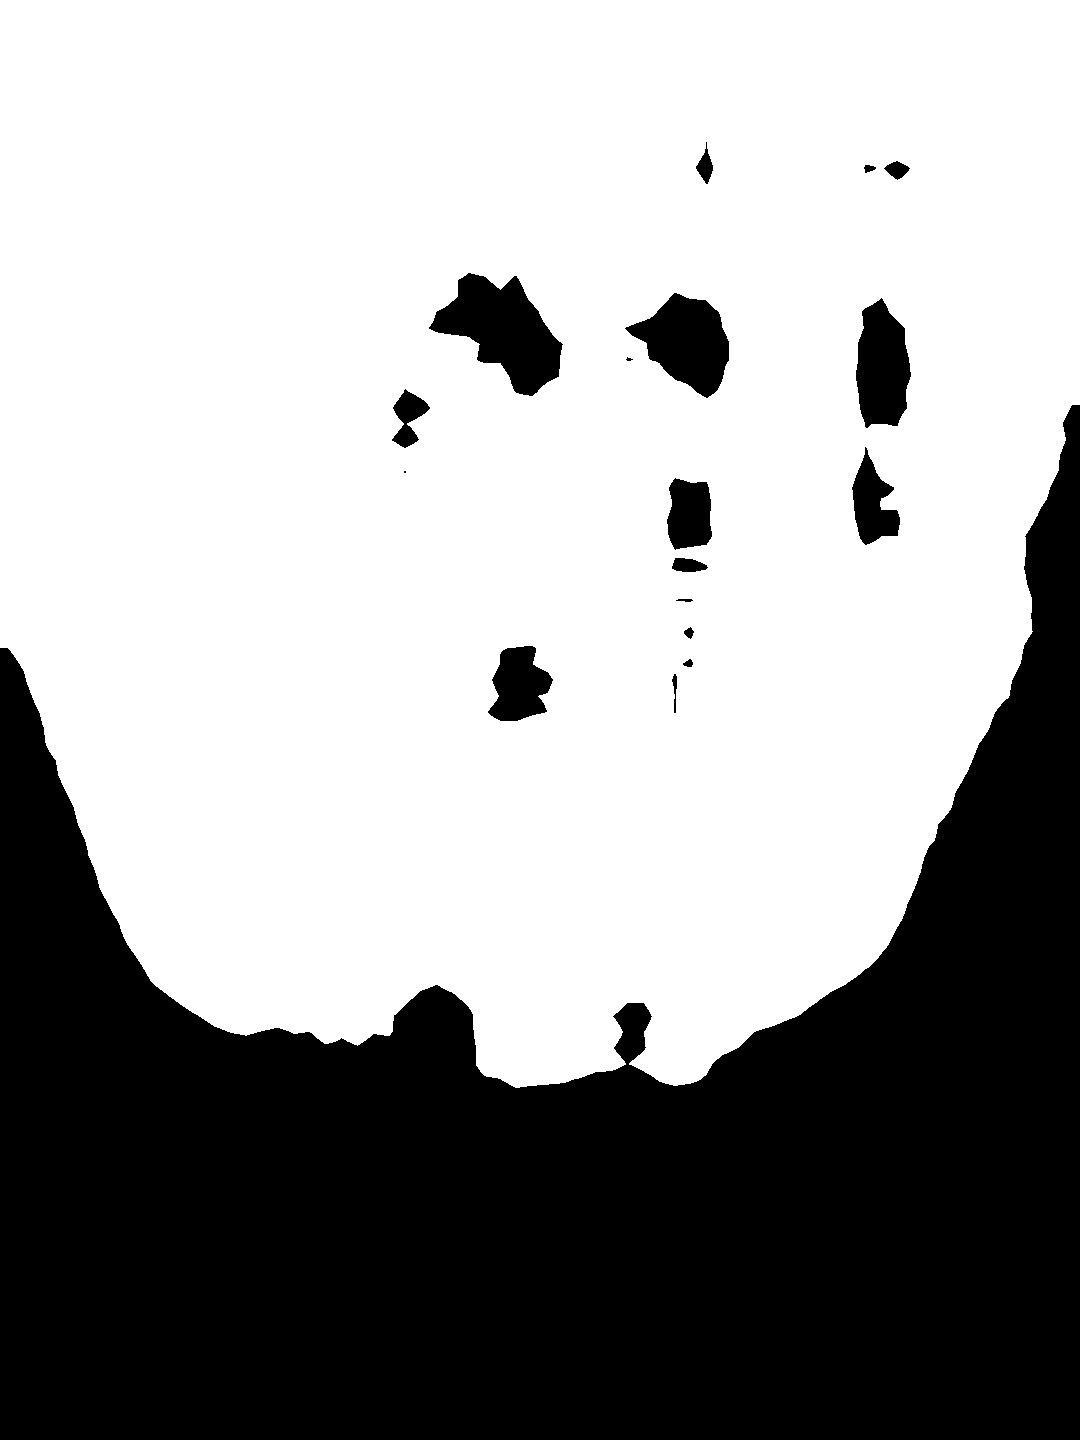

In [115]:
Image.fromarray(np.where(mask_3ch==1, 255,0).astype(np.uint8))

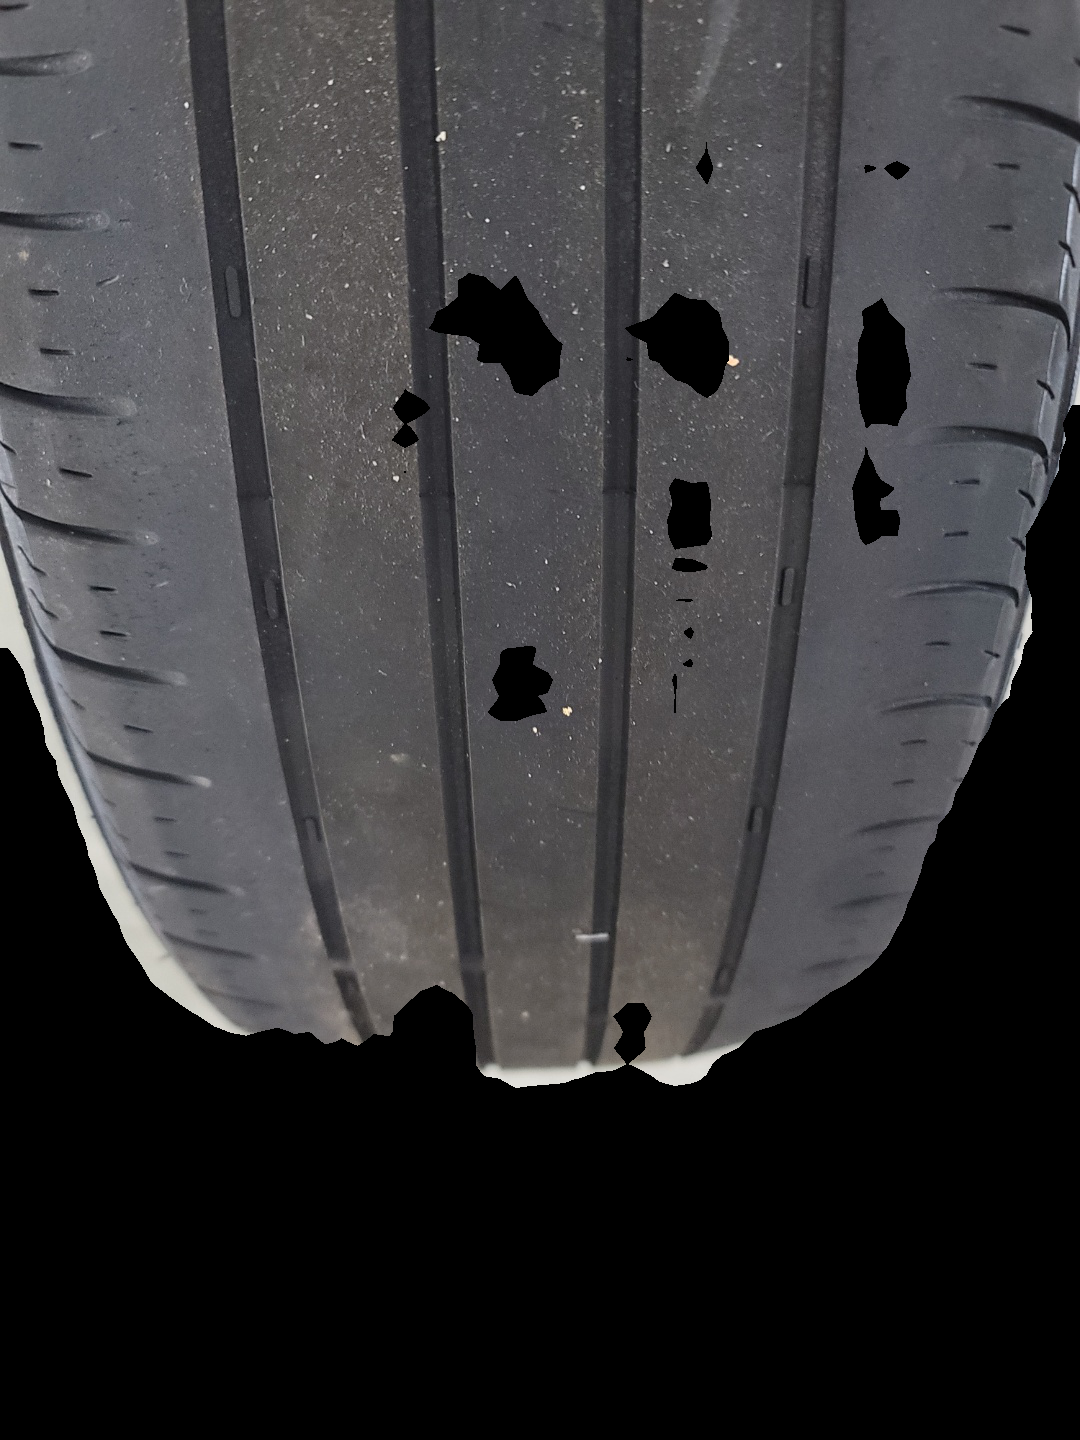

In [119]:
Image.fromarray(np.where(mask_3ch==1, img,0).astype(np.uint8))

(1440, 1080)


numpy.int32

In [125]:
def image_mask_filtered(img,pred):
    """_summary_

    Args:
        img (Image): _description_
        pred (np.array): _description_ H, W, 3

    Returns:
        _type_: _description_
    """
    sample = np.array(img)
    sample = sample[:,:,:3] # 채널 3음로변경하는 부분
    mask = np.expand_dims(pred, axis=2)
    mask_3ch = np.repeat(mask,[3],axis=2)
    masked_image = Image.fromarray(np.where(mask_3ch==1, img,0).astype(np.uint8))
    return masked_image


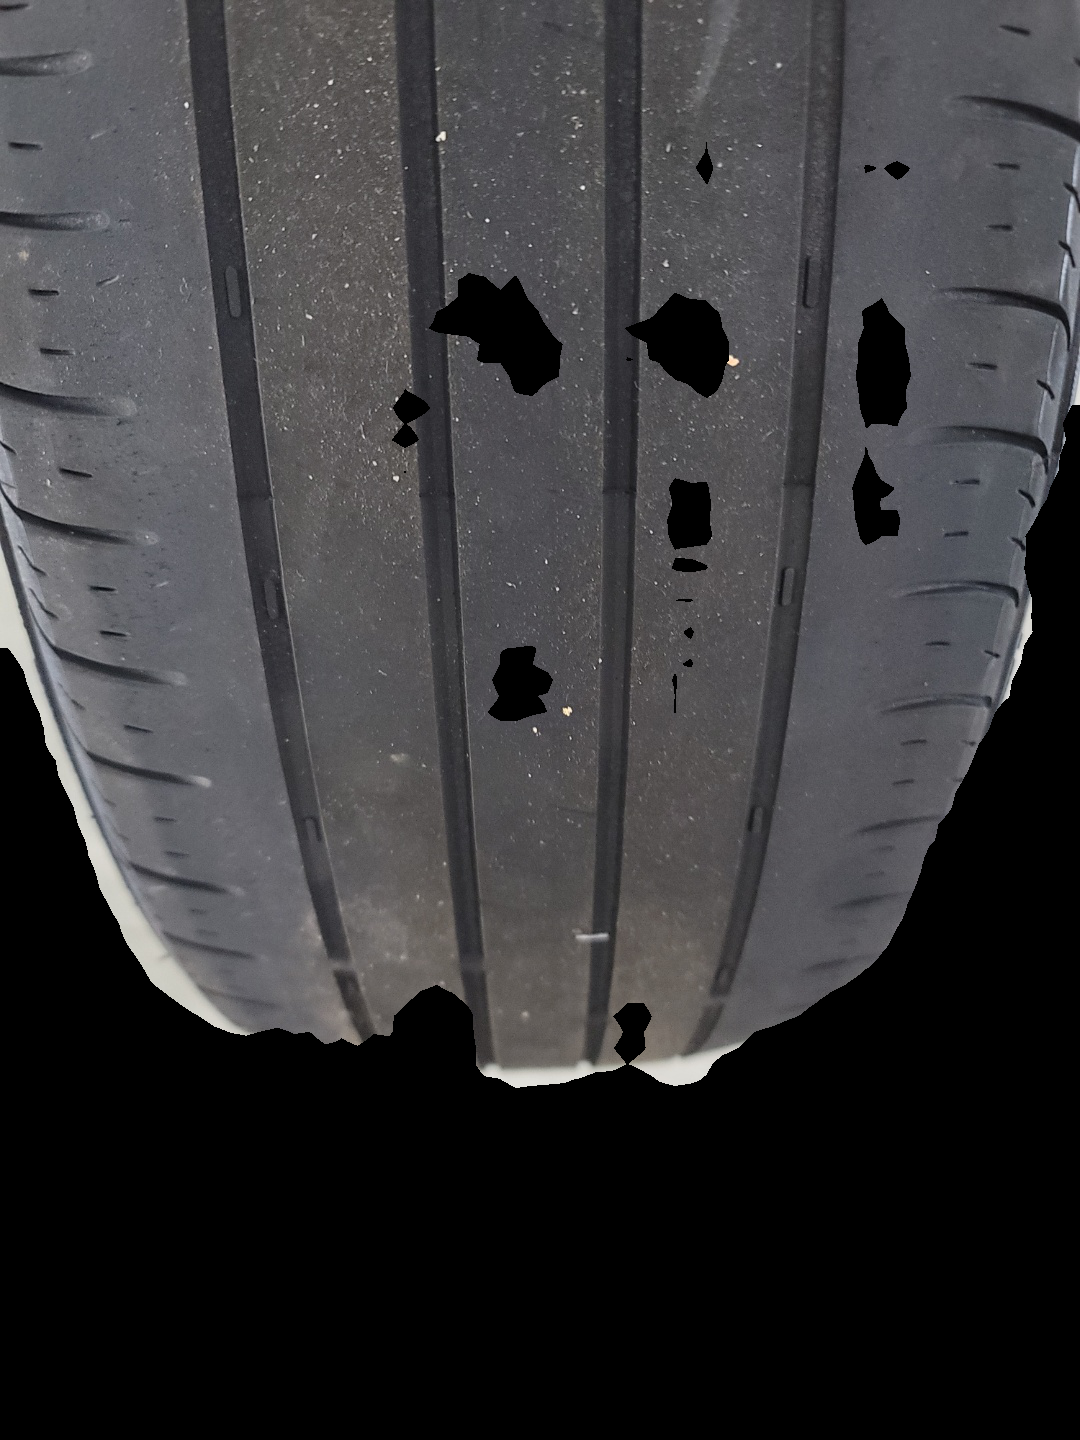

In [126]:

img = Image.open('./sample\\KakaoTalk_20220523_153854120_05.jpg')
image_mask_filtered(img, pred)